In [70]:
%matplotlib inline

In [63]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
import os
import re
import sys
import csv
import matplotlib.pyplot as plt
import seaborn as sns
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True

In [10]:
all_go=pd.read_csv("./ALL_GO_FUNCTIONS.csv",engine="python")

In [12]:
all_go=all_go.drop(["Class","Gene","Variation","Text","0"],axis=1)

In [32]:
trn=pd.read_csv("../checkpoints_databases/new_working_train.csv")

In [33]:
train=all_go[:len(trn)]
test=all_go[len(trn):]
y=trn.Class-1
del trn

In [51]:
tsvd_train= {}
tsvd_test={}
dic_svd=TruncatedSVD(n_components=35,n_iter=25,random_state=26)
tsvd_train=dic_svd.fit_transform(train.drop("ID",axis=1))
tsvd_test=dic_svd.transform(test.drop("ID",axis=1))
X_train=pd.DataFrame()
X_test=pd.DataFrame()

for i in range(35):
    X_train['tsvd_ext_'+str(i)] = tsvd_train[:, i]
    X_test['tsvd_ext_' +str(i)] = tsvd_test[:, i]

In [52]:
kf = model_selection.StratifiedKFold(n_splits=5, random_state=26, shuffle=True)

In [53]:
clf_xgb=XGBClassifier(max_depth=5, objective="multi:softprob",seed=26)
h=cross_val_score(clf_xgb,np.array(X_train),y,cv=kf,n_jobs=-1,scoring="neg_log_loss")

In [54]:
print("mean: "+str(h.mean()),
         "std: "+str(h.std()))

mean: -1.1507925596 std: 0.0551253740008


In [58]:
tr_genes=pd.read_csv("./meta_train_l1l2.csv")
tr_genes_1=tr_genes.drop(["ID","Text_words"],axis=1)

In [47]:
h2=cross_val_score(clf_xgb,np.array(tr_genes_1),y,cv=kf,n_jobs=-1,scoring="neg_log_loss")

In [48]:
print("mean: "+str(h2.mean()),
         "std: "+str(h2.std()))

mean: -1.62878312757 std: 0.0139739678935


In [65]:
table=pd.concat([tr_genes_1,X_train],axis=1)

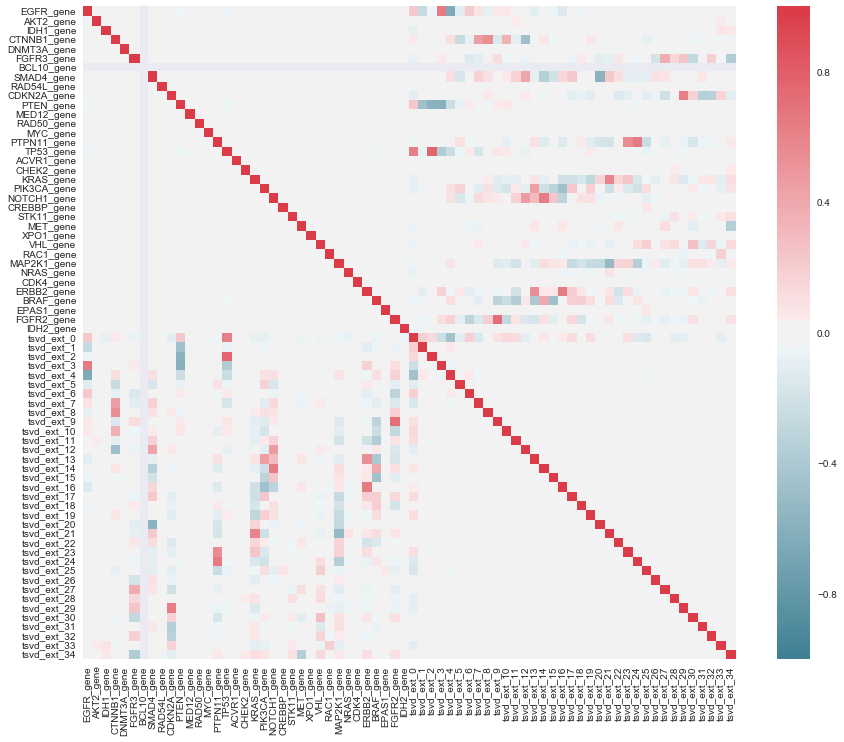

In [75]:
f,ax=plt.subplots(figsize=(15,12))
table_corr=table.corr()
sns.heatmap(table_corr,mask=np.zeros_like(table_corr,dtype=np.bool),cmap=sns.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
plt.show()

In [76]:
#Conclusion of this kernel : damn, go terms are superperforming alone and there are not so correlated to genes as the correlation said, 
#+ we can imagine the combinaisons of go terms + words to be incredibly strong, we will see on cross-validation on new_modelling 
#script my friend 

In [79]:
X_train.to_csv("new_working_train_ext.csv",index=False)
X_test.to_csv("new_working_test_ext.csv",index=False)